In [1]:
import torch
import torch.nn.functional as Func
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


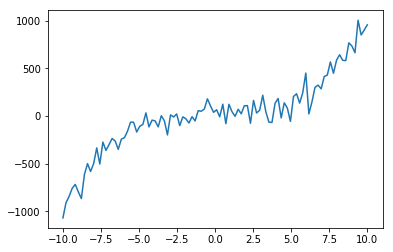

In [2]:
X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 10, std = 80)
y =  x**3 + noise
#y = 30*np.cos(x) + noise
plt.plot(x.data.numpy(), y.data.numpy())

In [3]:
class GaussianRegressorNLL(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, sizes, min_var = 1e-6):
        super(GaussianRegressorNLL, self).__init__()
        self.h = torch.zeros(n_input,sizes)
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.sizes = sizes
        self.layers = [self.hidden for i in range(sizes)]
        self.num_layers = sizes
    def forward(self,x):
        h = x
        output = []
        for i in range(self.num_layers):
            out = Func.relu(self.hidden(x))
            out = self.predict(out)
            output.append(out)
        mean, raw_var  = output
        mean = torch.sign(x)*mean
        var = Func.softplus(raw_var) + 1e-6
        return mean.view(-1,1), var.view(-1,1)

In [7]:
## Gaussian Loss Function
class GaussianNLL(torch.nn.Module):
    def __init__(self):
        super(GaussianNLL,self).__init__()
    def forward(self, mean_values, var_values, y):
        error = torch.sub(y, mean_values)
        loss =  0.5 *(torch.mean(torch.log(var_values)) + torch.mean(torch.div(torch.mul(error,error),var_values))+ torch.log(2*torch.tensor(np.pi)))
        return loss

## Comparing Uncertainty using MSELoss and NLLLoss

In [8]:
model_nll = GaussianRegressorNLL(x.size()[0], 100, y.size()[0], sizes = 2)
model_mse = GaussianRegressorNLL(x.size()[0], 100, y.size()[0], sizes = 2)

In [10]:
learning = {'mse': 0.00001,
             'nll': 0.01}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

## Hyper-parameters
alpha = 0.3
clipping = 0.25
num_iter = 50000
eps = 1e-2

In [11]:
learning_rate_mse = learning['mse']
loss_mse = loss_dict['mse']
optimizer_mse = optim.Adam(model_mse.parameters(),learning_rate_mse)
loss_mse, learning_rate_mse

(MSELoss(), 1e-05)

In [12]:
learning_rate_nll = learning['nll']
loss_nll = loss_dict['nll']
optimizer_nll = optim.Adam(model_nll.parameters(),learning_rate_nll)
loss_nll, learning_rate_nll

(GaussianNLL(), 0.01)

Iter: 0, Loss MSE: 158668.234375
Iter: 0, Loss NLL: 191315.3125


/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()
/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


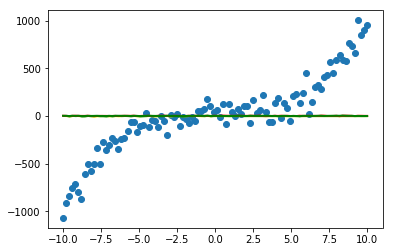

Iter: 5000, Loss MSE: 117378.546875
Iter: 5000, Loss NLL: 23.15258026123047


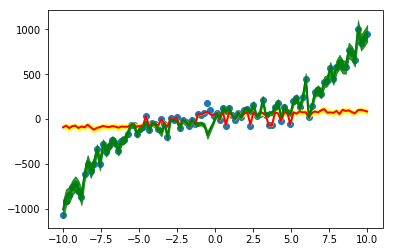

Iter: 10000, Loss MSE: 57890.01953125
Iter: 10000, Loss NLL: 22.47345542907715


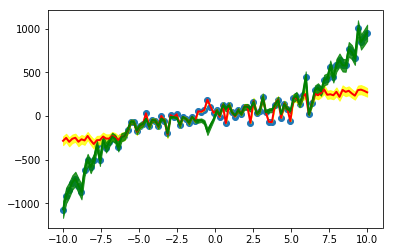

Iter: 15000, Loss MSE: 16091.5673828125
Iter: 15000, Loss NLL: 35.303199768066406


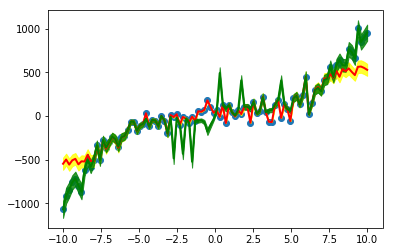

Iter: 20000, Loss MSE: 1309.1531982421875
Iter: 20000, Loss NLL: 33.974830627441406


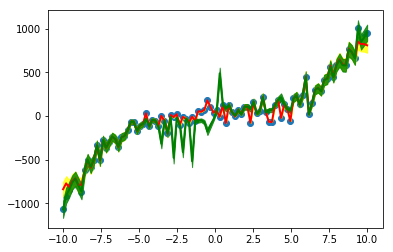

Iter: 25000, Loss MSE: 7.079602241516113
Iter: 25000, Loss NLL: 29.627761840820312


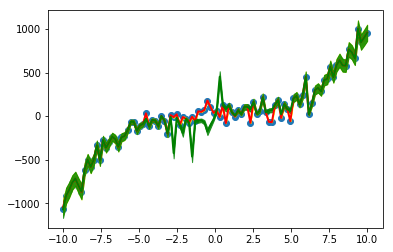

Iter: 30000, Loss MSE: 7.110754154382448e-07
Iter: 30000, Loss NLL: 24.597206115722656


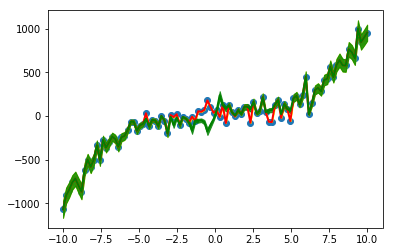

Iter: 35000, Loss MSE: 2.663123268575873e-07
Iter: 35000, Loss NLL: 22.299978256225586


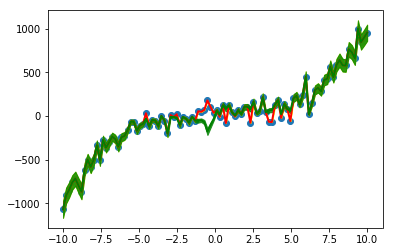

Iter: 40000, Loss MSE: 5.562885263543649e-08
Iter: 40000, Loss NLL: 22.291418075561523


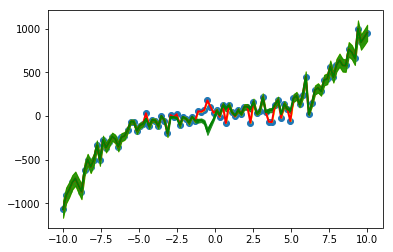

Iter: 45000, Loss MSE: 9.398520717240899e-08
Iter: 45000, Loss NLL: 22.291202545166016


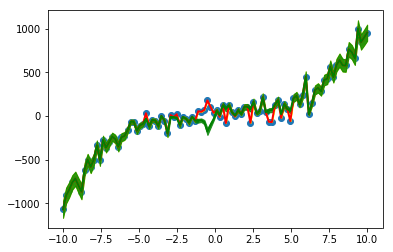

In [13]:
for i in range(num_iter):
    ## updating MSE preds
    preds_mse, var_mse = model_mse(Variable(x.view(1,-1)))
    lo_mse = loss_mse(preds_mse, y)
    (alpha * lo_mse).backward()
    optimizer_mse.step()
    optimizer_mse.zero_grad()
    
    ## updating NLL preds
    preds_nll, var_nll = model_nll(Variable(x.view(1,-1)))
    lo_nll = loss_nll(preds_nll, var_nll, y)
    (alpha * lo_nll).backward()
    optimizer_nll.step()
    optimizer_nll.zero_grad()
        
    torch.nn.utils.clip_grad_norm(model_mse.parameters(), clipping)
    torch.nn.utils.clip_grad_norm(model_nll.parameters(), clipping)
    
    if i %5000 ==0:
        print("Iter: {}, Loss MSE: {}".format(i, lo_mse.data.numpy()))
        print("Iter: {}, Loss NLL: {}".format(i, lo_nll.data.numpy()))
        
        std_mse = np.sqrt(var_mse.data.numpy())
        upper_mse = preds_mse.data.numpy() + 3 * std_mse
        lower_mse = preds_mse.data.numpy() - 3 * std_mse
        
        std_nll = np.sqrt(var_nll.data.numpy())
        upper_nll = preds_nll.data.numpy() + 3 * std_nll
        lower_nll = preds_nll.data.numpy() - 3 * std_nll
        
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds_mse.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_mse.squeeze(), upper_mse.squeeze(), color='yellow', alpha=0.8)
        
        plt.plot(x.data.numpy(), preds_nll.view(-1,1).data.numpy(), 'g-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_nll.squeeze(), upper_nll.squeeze(), color='green', alpha=0.8)
        
        plt.pause(0.1)
plt.ioff()
plt.show()

##  NLL - Ensemble

In [15]:
def mean_var_ensemble(ensemble, x):
    en_mean = 0
    en_var = 0
    for i,model in enumerate(ensemble):
        mean,var = model(Variable(x.view(1,-1)))
        en_mean += mean
        en_var += var + mean ** 2
    en_mean /= len(ensemble)
    en_var /= len(ensemble)
    en_var -= en_mean ** 2
    return en_mean.data.numpy(), en_var.data.numpy()

In [17]:
alpha = 0.1
clipping = 0.25
max_iter = 20000
K = 5  # ensemble size
eps = 1e-2

learning = {'mse': 0.00001,
             'nll': 0.05}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

define_loss = 'nll'
ensemble = [GaussianRegressorNLL(x.size()[0], 100, y.size()[0],2) for i in range(K)]
learning_rate = learning[define_loss]
loss_function = loss_dict[define_loss]
optimizer = [optim.Adam(ensemble[i].parameters(),learning_rate) for i in range(K)]
losses =[loss_function for i in range(K)]

In [18]:
loss_function, learning_rate

(GaussianNLL(), 0.05)

Iter: 0, Loss: 240311.015625


/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if __name__ == '__main__':


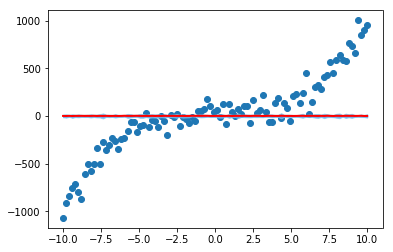

Iter: 1000, Loss: 184.35731506347656


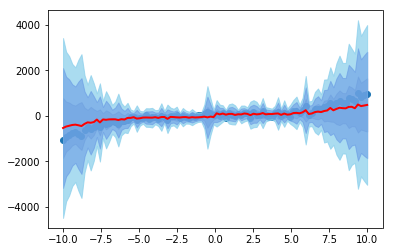

Iter: 2000, Loss: 32.76390075683594


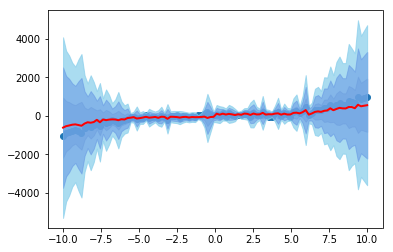

Iter: 3000, Loss: 25.150110244750977


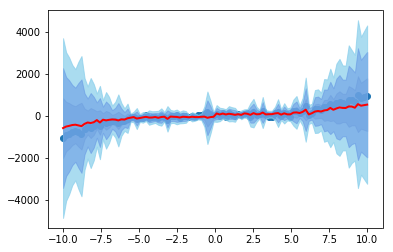

Iter: 4000, Loss: 28.51508331298828


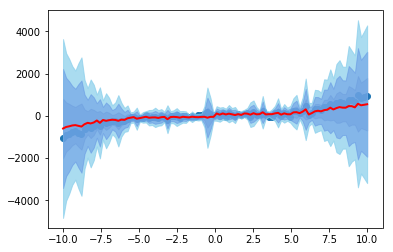

Iter: 5000, Loss: 41.01939010620117


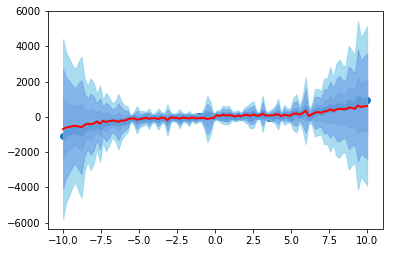

Iter: 6000, Loss: 25.069543838500977


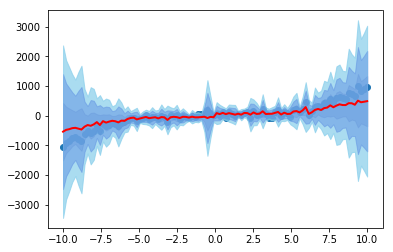

Iter: 7000, Loss: 26.909574508666992


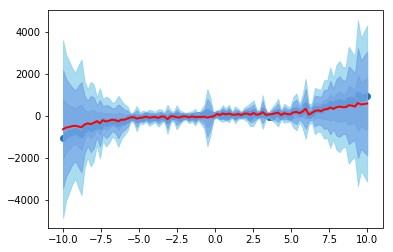

Iter: 8000, Loss: 31.400279998779297


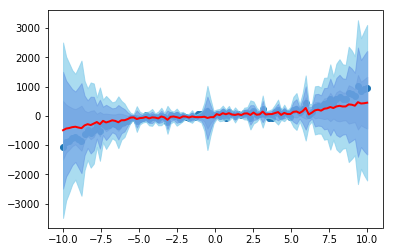

Iter: 9000, Loss: 25.740352630615234


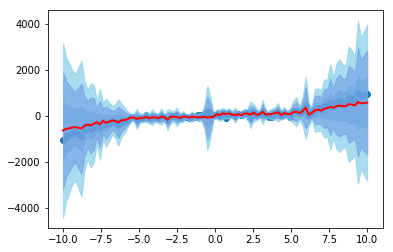

Iter: 10000, Loss: 28.303110122680664


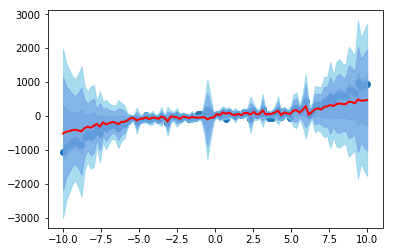

Iter: 11000, Loss: 24.663597106933594


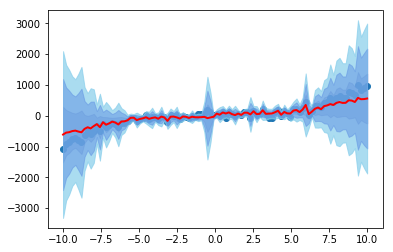

Iter: 12000, Loss: 26.67483139038086


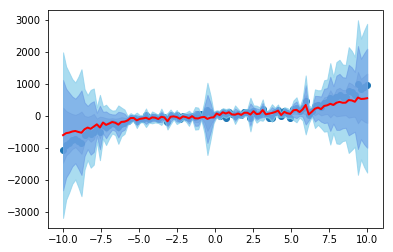

Iter: 13000, Loss: 25.84459686279297


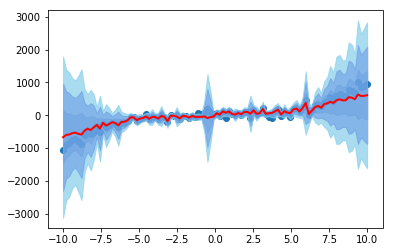

Iter: 14000, Loss: 29.25572967529297


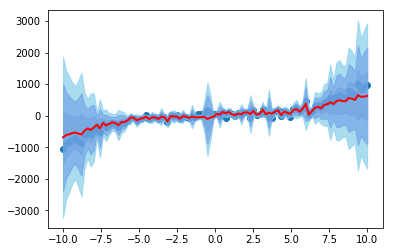

Iter: 15000, Loss: 24.07462501525879


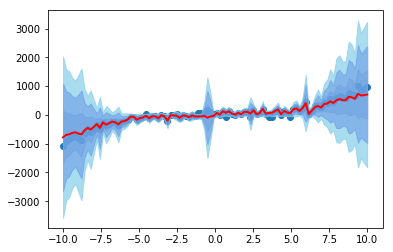

Iter: 16000, Loss: 35.39019775390625


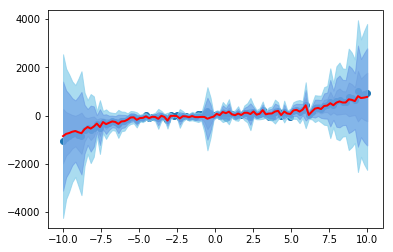

Iter: 17000, Loss: 25.316619873046875


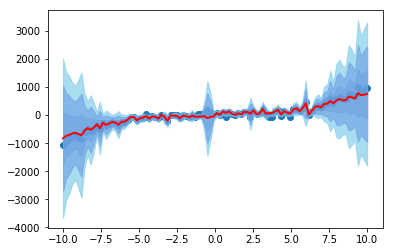

Iter: 18000, Loss: 28.631061553955078


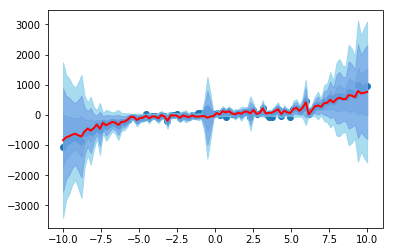

Iter: 19000, Loss: 27.999732971191406


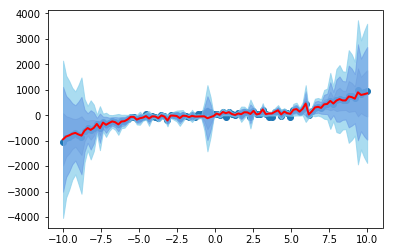

In [19]:
for i in range(max_iter):
    for model, opt, loss in zip(ensemble, optimizer, losses):
        preds, var = model(Variable(x.view(1,-1)))
        if define_loss == 'nll':
            loss = loss_function(preds, var, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), clipping)
    
        elif define_loss == 'mse':
            loss = loss_function(preds, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            
    if i %1000 ==0:
        print("Iter: {}, Loss: {}".format(i, loss.data.numpy()))
        mean_en, var_en = mean_var_ensemble(ensemble, x)
        std = np.sqrt(var_en)
        upper_3 = mean_en + 3 * std
        lower_3 = mean_en - 3 * std
        upper_6 = mean_en + 6 * std
        lower_6 = mean_en - 6 * std
        upper_9 = mean_en + 9 * std
        lower_9 = mean_en - 9 * std
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy().squeeze(), mean_en.squeeze(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
        plt.fill_between(x.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
        plt.fill_between(x.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

        plt.pause(0.1)
plt.ioff()
plt.show()